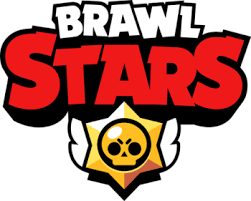

## Brawl Stars Data Science - Predict a win or loss for top players - Model

This script builds the ML pipeline that will be able to predict the outcome of a battle. 

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from datetime import datetime
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold

# Import functions
from parameters import *  # Change to parameters_template and add your API KEY.
from utils.duplicate_battles import *
from utils.save_battles import *

In [2]:
# Get list of all files already stored in database
file_names = [f for f in listdir(loc) if isfile(join(loc, f))]

In [3]:
# Read all the files and store in one dataframe
all_data = pd.DataFrame()

for i in file_names:
    temp_df = pd.read_csv(filepath_or_buffer = loc+'/'+i, index_col=0)
    all_data = pd.concat([all_data, temp_df])

In [4]:
# Remove duplicate battles
len_bef = len(all_data)
all_data = all_data.drop_duplicates(subset='unq_battle_id', keep='first')
print('{} out of {} Battles removed. {} Battles remaining.'. format(len_bef-len(all_data), len_bef, len(all_data)))

6122 out of 55821 Battles removed. 49699 Battles remaining.


In [5]:
all_data.reset_index(drop=True, inplace=True)

In [6]:
# Create one feature for mode and map
all_data['mode_map'] = [all_data.loc[x,'mode'] + "_" + all_data.loc[x,'map'] for x in range(len(all_data))]

# Remove unnecessary columns
all_data.drop(columns=['map','mode','type','unq_battle_id'], inplace=True)

In [7]:
# # Keep only mode_maps with enough data (based on number of battles)
# maps_to_keep = list(all_data['mode_map'].value_counts()[all_data['mode_map'].value_counts()>bat_per_map_mode].index)

# Or keep only the first map
maps_to_keep = [all_data['mode_map'].value_counts().index[0]]

len_bef = len(all_data)
all_data = all_data[all_data['mode_map'].isin(maps_to_keep)]
print('Map(s) to keep: {}'.format(maps_to_keep))
print('{} out of {} Battles removed. {} Battles remaining.'. format(len_bef-len(all_data), len_bef, len(all_data)))

Map(s) to keep: ['brawlBall_Sticky Notes']
35325 out of 49699 Battles removed. 14374 Battles remaining.


In [8]:
all_data.reset_index(drop=True, inplace=True)

In [9]:
all_data

,pl1_tm1_brawler,pl1_tm1_brwlr_trop,pl1_tm1_brwlr_pwr,pl2_tm1_brawler,pl2_tm1_brwlr_trop,pl2_tm1_brwlr_pwr,pl3_tm1_brawler,pl3_tm1_brwlr_trop,pl3_tm1_brwlr_pwr,pl1_tm2_brawler,pl1_tm2_brwlr_trop,pl1_tm2_brwlr_pwr,pl2_tm2_brawler,pl2_tm2_brwlr_trop,pl2_tm2_brwlr_pwr,pl3_tm2_brawler,pl3_tm2_brwlr_trop,pl3_tm2_brwlr_pwr,tm1_win,mode_map
0,TARA,998,10,COLT,922,10,SHELLY,926,10,BUZZ,775,10,COLONEL RUFFS,799,10,NITA,782,10,True,brawlBall_Sticky Notes
1,EL PRIMO,901,10,BYRON,946,10,BUZZ,731,10,NITA,798,10,DYNAMIKE,787,10,BELLE,731,10,False,brawlBall_Sticky Notes
2,DARRYL,813,10,EL PRIMO,781,10,MORTIS,781,10,EL PRIMO,891,10,BYRON,936,10,SURGE,767,10,False,brawlBall_Sticky Notes
3,BEA,806,10,BUZZ,928,10,SPIKE,873,10,BELLE,871,10,STU,911,10,FRANK,956,10,False,brawlBall_Sticky Notes
4,EL PRIMO,898,10,BYRON,942,10,SURGE,793,10,SPIKE,757,10,NITA,824,10,BROCK,775,10,False,brawlBall_Sticky Notes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14369,BUZZ,721,10,JESSIE,677,9,COLT,733,10,SURGE,724,10,BUZZ,724,10,MORTIS,727,10,True,brawlBall_Sticky Notes
14370,SPROUT,759,10,STU,790,10,EL PRIMO,700,10,EL PRIMO,774,10,COLT,817,10,STU,798,10,False,brawlBall_Sticky Notes
14371,COLT,668,10,TICK,658,10,COLONEL RUFFS,650,10,MORTIS,663,9,JESSIE,654,10,DYNAMIKE,663,10,True,brawlBall_Sticky Notes
14372,MORTIS,715,10,SURGE,802,10,LEON,765,10,DARRYL,757,10,BEA,786,10,GRIFF,807,10,False,brawlBall_Sticky Notes


### 1st Try: Only use trophies and power levels

In [10]:
# 1st try: only predict based on the trophies
df = all_data.copy()

In [11]:
df.drop(columns = ['mode_map', 'pl1_tm1_brawler', 'pl2_tm1_brawler', 'pl3_tm1_brawler',
                   'pl1_tm2_brawler', 'pl2_tm2_brawler', 'pl3_tm2_brawler'], inplace=True)

In [12]:
df.drop(columns=['tm1_win'])

,pl1_tm1_brwlr_trop,pl1_tm1_brwlr_pwr,pl2_tm1_brwlr_trop,pl2_tm1_brwlr_pwr,pl3_tm1_brwlr_trop,pl3_tm1_brwlr_pwr,pl1_tm2_brwlr_trop,pl1_tm2_brwlr_pwr,pl2_tm2_brwlr_trop,pl2_tm2_brwlr_pwr,pl3_tm2_brwlr_trop,pl3_tm2_brwlr_pwr
0,998,10,922,10,926,10,775,10,799,10,782,10
1,901,10,946,10,731,10,798,10,787,10,731,10
2,813,10,781,10,781,10,891,10,936,10,767,10
3,806,10,928,10,873,10,871,10,911,10,956,10
4,898,10,942,10,793,10,757,10,824,10,775,10
...,...,...,...,...,...,...,...,...,...,...,...,...
14369,721,10,677,9,733,10,724,10,724,10,727,10
14370,759,10,790,10,700,10,774,10,817,10,798,10
14371,668,10,658,10,650,10,663,9,654,10,663,10
14372,715,10,802,10,765,10,757,10,786,10,807,10


In [13]:
X = df.drop(columns=['tm1_win'])
y = df['tm1_win'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [14]:
# create an xgboost regression model (no hyperparameter)
model = XGBClassifier(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

In [15]:
model.fit(X_train, y_train)

C:\Users\skoupras\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:04:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=8, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [16]:
# make predictions for test data
y_pred = pd.Series(model.predict(X_test), index = y_test.index)

C:\Users\skoupras\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [17]:
y_pred = pd.Series([0 if x<=0.5 else 1 for x in y_pred], index = y_test.index)

In [18]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 57.43%


In [19]:
# With hyperparameter tuning
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [4, 5, 6, 7, 8]
        }

In [20]:
model = XGBClassifier(learning_rate=0.02, n_estimators=1000, objective='binary:logistic', nthread=1)

In [21]:
folds = 3
iterations = 20

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

In [22]:
# See all scoring metri
random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=iterations,
                                   scoring='accuracy', n_jobs=4, cv=skf.split(X,y), verbose=3, random_state=1001 )

In [23]:
random_search.fit(X, y)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.9min finished
C:\Users\skoupras\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:07:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x00000213BDD2AA48>,
                   error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=0.02,
                                           max_delta_step=None, max_depth=None,
                                           min_child...
                                           use_label_encoder=True,
                                           validate_parameters=None,
                                           verbosity=None),
                   iid='deprecated', n_iter=20, n_

In [24]:
print('\n All test scores:')
print(random_search.cv_results_['mean_test_score'])
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best score:')
print(random_search.best_score_)
print('\n Best hyperparameters:')
print(random_search.best_params_)


 All test scores:
[0.59218013 0.59218005 0.59176218 0.5921105  0.5880057  0.58515385
 0.59287539 0.59078866 0.59162358 0.59037136 0.59009264 0.58814506
 0.58974471 0.58932749 0.59134529 0.59614532 0.59864986 0.58619672
 0.58925836 0.58494513]

 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=1, nthread=1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

 Best score:
0.5986498578825281

 Best hyperparameters:
{'subsamp

In [25]:
random_search.best_score_

0.5986498578825281